##Importing necessary libraries

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

##dataset Overview

In [2]:
import pandas as pd

# Download and load the dataset
url = "https://raw.githubusercontent.com/GuviMentor88/Training-Datasets/refs/heads/main/twitter_training.csv"
df = pd.read_csv(url)

# Display the first few rows
print(df.head())

   2401  Borderlands  Positive  \
0  2401  Borderlands  Positive   
1  2401  Borderlands  Positive   
2  2401  Borderlands  Positive   
3  2401  Borderlands  Positive   
4  2401  Borderlands  Positive   

  im getting on borderlands and i will murder you all ,  
0  I am coming to the borders and I will kill you...     
1  im getting on borderlands and i will kill you ...     
2  im coming on borderlands and i will murder you...     
3  im getting on borderlands 2 and i will murder ...     
4  im getting into borderlands and i can murder y...     


In [3]:
# Assigning column names
df.columns = ['Tweet_id', 'Location', 'Review', 'Tweets']
print(df)

       Tweet_id     Location    Review  \
0          2401  Borderlands  Positive   
1          2401  Borderlands  Positive   
2          2401  Borderlands  Positive   
3          2401  Borderlands  Positive   
4          2401  Borderlands  Positive   
...         ...          ...       ...   
74676      9200       Nvidia  Positive   
74677      9200       Nvidia  Positive   
74678      9200       Nvidia  Positive   
74679      9200       Nvidia  Positive   
74680      9200       Nvidia  Positive   

                                                  Tweets  
0      I am coming to the borders and I will kill you...  
1      im getting on borderlands and i will kill you ...  
2      im coming on borderlands and i will murder you...  
3      im getting on borderlands 2 and i will murder ...  
4      im getting into borderlands and i can murder y...  
...                                                  ...  
74676  Just realized that the Windows partition of my...  
74677  Just realized th

In [4]:
df.shape

(74681, 4)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Tweet_id  74681 non-null  int64 
 1   Location  74681 non-null  object
 2   Review    74681 non-null  object
 3   Tweets    73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [6]:
df.isnull().sum()

,0
Tweet_id,0
Location,0
Review,0
Tweets,686


In [7]:
#duplicate
df.duplicated().sum()

2700

In [8]:
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

In [9]:
df.drop(columns=['Tweet_id', 'Location'], inplace=True)

In [10]:
# Replace "Irrelevant" with "Neutral"
df['Review'] = df['Review'].replace('Irrelevant', 'Neutral')

# Label Encoding
sentiment_mapping = {'Positive': 1, 'Negative': 2, 'Neutral': 0}
df['Review'] = df['Review'].map(sentiment_mapping)

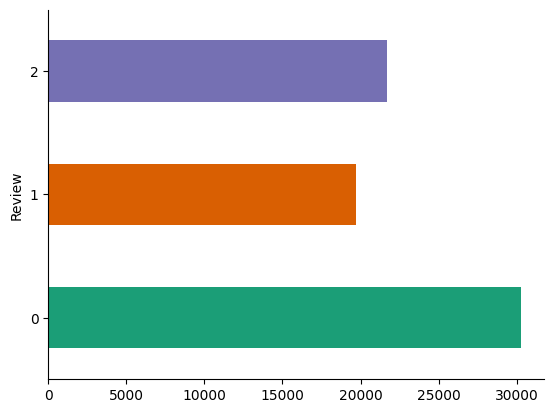

In [11]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Review').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

(-0.5, 1439.5, 1079.5, -0.5)

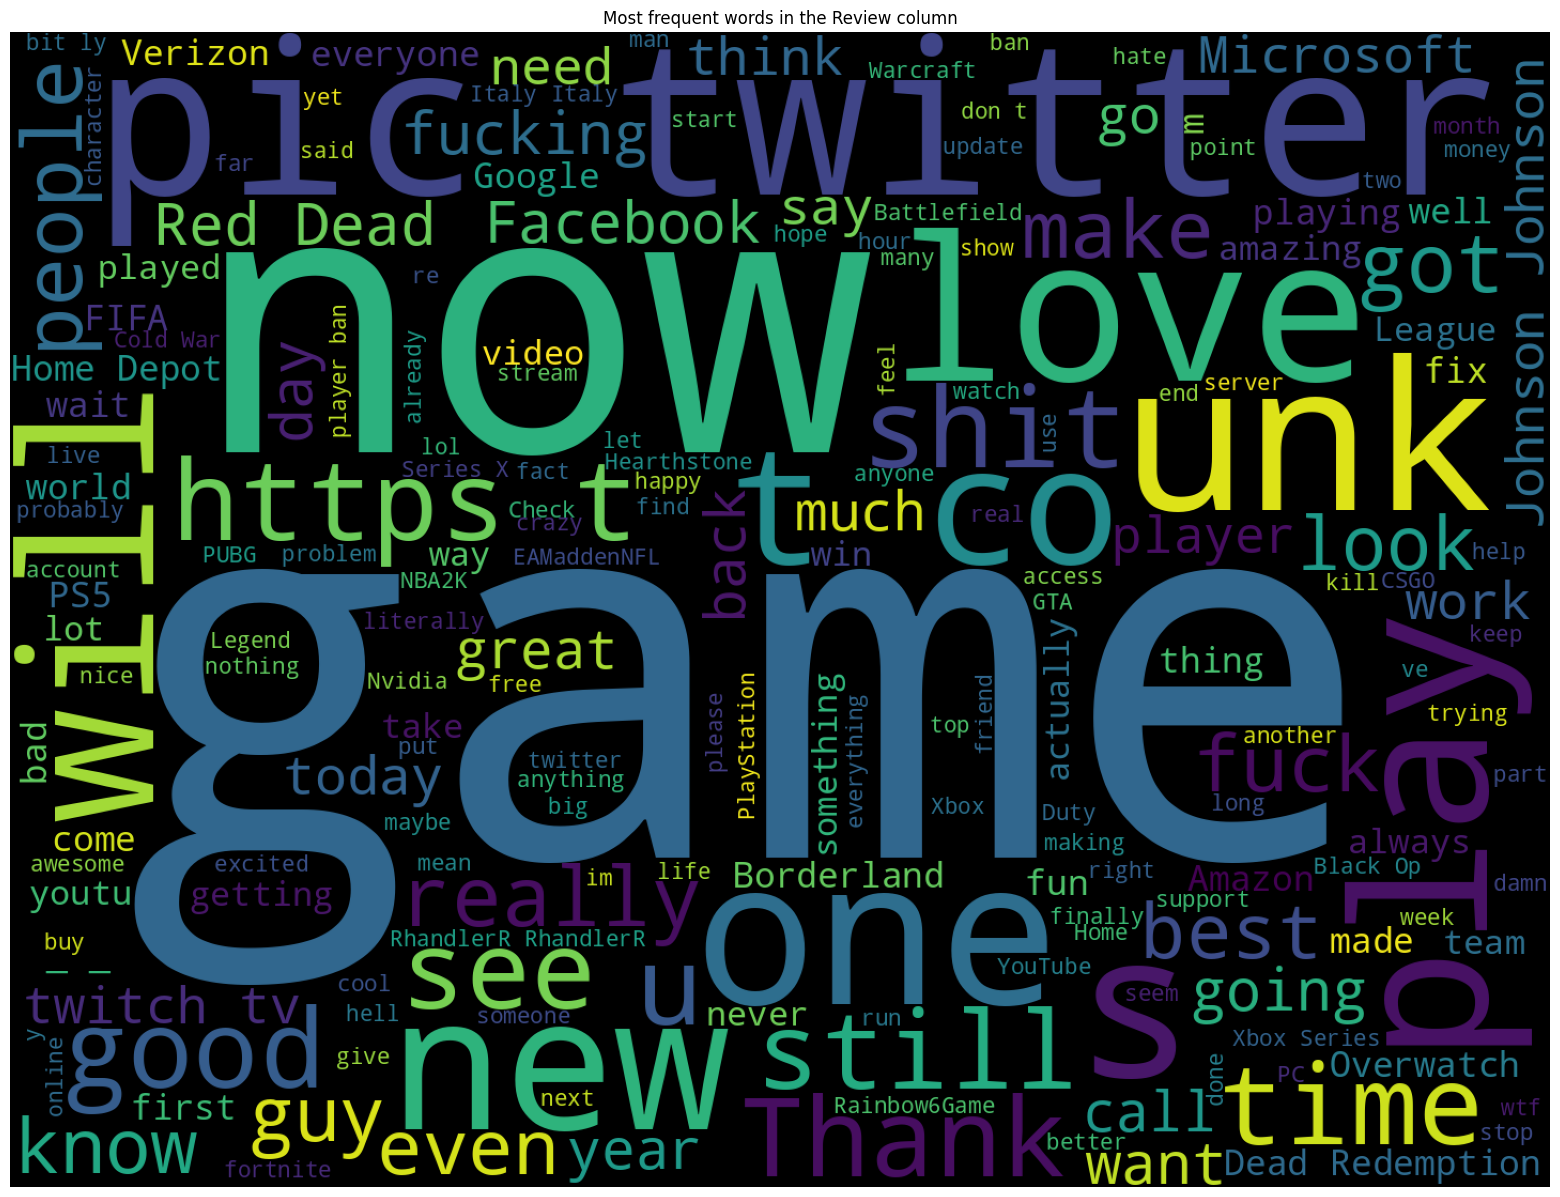

In [12]:
train = pd.Series(df['Tweets'].tolist()).astype(str)
cloud = WordCloud(width=1440, height=1080,stopwords=STOPWORDS).generate(" ".join(train.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.title("Most frequent words in the Review column")
plt.axis('off')

In [13]:
df.columns

Index(['Review', 'Tweets'], dtype='object')

In [14]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

In [15]:
df.to_csv("cleaned_dataset.csv", index=False)

In [16]:
!pip install torch transformers datasets torch scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [17]:
import torch
torch.cuda.is_available()

True

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
device = torch.device("cuda")

In [20]:
device


device(type='cuda')

In [21]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [22]:
import torch
from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
)
from datasets import Dataset
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.model_selection import train_test_split

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Train-test split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['Tweets'], df['Review'], test_size=0.2, random_state=42
)

# Convert to Dataset
train_dataset = Dataset.from_dict({"text": train_texts.astype(str), "label": train_labels})  # Convert Text to numerical
val_dataset = Dataset.from_dict({"text": val_texts.astype(str), "label": val_labels})

# Tokenizer and Tokenization

# Load a pre-trained tokenizer to preprocess text into token IDs and attention masks.
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

# Remove text column
train_dataset = train_dataset.remove_columns(['text'])  # Purpose: Keep only the columns required for model input.
val_dataset = val_dataset.remove_columns(['text'])

# Load the DistilBERT model and move it to the GPU

# Purpose: Load a pre-trained DistilBERT model and set it up for a 3-class classification task (Positive, Negative, Neutral)

model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=3  # Adjust for the number of classes
).to(device)

# Metrics calculation
# Purpose: Calculate evaluation metrics like accuracy, precision, recall, and F1 score.

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    logits = torch.tensor(logits).to(device)  # Ensure logits are on GPU
    labels = torch.tensor(labels).to(device)  # Ensure labels are on GPU
    predictions = torch.argmax(logits, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels.cpu(), predictions.cpu(), average='weighted')
    acc = accuracy_score(labels.cpu(), predictions.cpu())
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# Training arguments

# Purpose: Define training parameters like batch size, learning rate, and logging.

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,  # Increased for better training
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    fp16=True  # Enable mixed precision
)

# Trainer
# Purpose: Set up the training and evaluation process.

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Train and evaluate
trainer.train()
results = trainer.evaluate()
print("Evaluation Results:", results)


Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/55755 [00:00<?, ? examples/s]

Map:   0%|          | 0/13939 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-22-4756776f460b>:84: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.410100,0.414917,0.844393,0.845946,0.844393,0.844790
2,0.195200,0.296376,0.906665,0.906948,0.906665,0.906714
3,0.138500,0.311592,0.926824,0.926779,0.926824,0.926758
4,0.068200,0.344841,0.936581,0.936617,0.936581,0.936531


Evaluation Results: {'eval_loss': 0.29637566208839417, 'eval_accuracy': 0.9066647535691226, 'eval_precision': 0.9069476863178451, 'eval_recall': 0.9066647535691226, 'eval_f1': 0.9067141585712771, 'eval_runtime': 15.3231, 'eval_samples_per_second': 909.673, 'eval_steps_per_second': 56.908, 'epoch': 4.0}


In [38]:
# Save model and tokenizer
model.save_pretrained("./fine_tuned_distilbert")

tokenizer.save_pretrained("./fine_tuned_distilbert")

('./fine_tuned_distilbert/tokenizer_config.json',
 './fine_tuned_distilbert/special_tokens_map.json',
 './fine_tuned_distilbert/vocab.txt',
 './fine_tuned_distilbert/added_tokens.json',
 './fine_tuned_distilbert/tokenizer.json')

In [39]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import torch.nn.functional as F

# Load fine-tuned model and tokenizer
model_path = "/content/fine_tuned_distilbert"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

In [40]:
def predict_sentiment(texts):
    # Tokenize input texts
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=128)

    # Get model predictions
    with torch.no_grad():
        outputs = model(**inputs)

    # Apply softmax to get probabilities
    probs = F.softmax(outputs.logits, dim=-1)

    # Get class probabilities and format the output
    results = []
    for i, prob in enumerate(probs):
        result = {
            "Text": texts[i],
            "Probabilities": {
                "Neutral": round(prob[0].item(), 4),
                "Positive": round(prob[1].item(), 4),
                "Negative": round(prob[2].item(), 4)
            }
        }
        results.append(result)
    return results

In [41]:
texts = [
    "I love this product!",
    "This is the worst experience ever.",
    "guvi has the best data science road map in industry"
]

predictions = predict_sentiment(texts)

# Display results
for prediction in predictions:
    print(f"Text: {prediction['Text']}")
    for sentiment, prob in prediction["Probabilities"].items():
        print(f"  {sentiment}: {prob}")
    print()

Text: I love this product!
  Neutral: 0.0205
  Positive: 0.9741
  Negative: 0.0055

Text: This is the worst experience ever.
  Neutral: 0.0062
  Positive: 0.015
  Negative: 0.9788

Text: guvi has the best data science road map in industry
  Neutral: 0.1167
  Positive: 0.8807
  Negative: 0.0026



In [35]:
!pip install flask

In [36]:
pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.4/321.4 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.8 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [42]:
import gradio as gr
import torch
import torch.nn.functional as F
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from flask import request
import logging
from datetime import datetime

# Load fine-tuned model and tokenizer
model_path = "/content/fine_tuned_distilbert"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Set up logging
logging.basicConfig(
    filename="user_logs.txt",  # Logs will be saved to this file
    level=logging.INFO,
    format="%(asctime)s - %(message)s",
)

def log_user_details(user_ip, input_text):
    log_message = f"IP: {user_ip} | Input: {input_text}"
    logging.info(log_message)
    print(log_message)  # Optional: Print logs for testing in Colab

def predict_sentiment(text):
    # Get user IP address (only works with Flask requests)
    user_ip = request.remote_addr if request else "Unknown IP"
    log_user_details(user_ip, text)

    # Predict sentiment
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    probs = F.softmax(outputs.logits, dim=-1)
    # Get class probabilities and format the output
    result = {
        "Negative": round(probs[0][2].item(), 4),
        "Neutral": round(probs[0][0].item(), 4),
        "Positive": round(probs[0][1].item(), 4),
    }
    return result

iface = gr.Interface(
    fn=predict_sentiment,
    inputs=gr.Textbox(lines=2, placeholder="Enter text here..."),
    outputs=gr.JSON(),
    title="Twitter Tweets Sentiment Analysis",
    description="Enter Tweets and get the predicted sentiment probabilities."
)

iface.launch(share=True)  # `share=True` creates a public URL

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f4a03b1b4074d7a702.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
